# MS COCO Datataset EDA

In [ ]:
!pip install datasets matplotlib pandas seaborn

import os
from datasets import load_dataset
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import numpy as np

In [ ]:
os.makedirs("eda_plots", exist_ok=True)
print("Setup complete. Libraries installed and 'eda_plots' directory is ready.")


Setup complete. Libraries installed and 'eda_plots' directory is ready.


## loading the dataset


In [ ]:

coco_data = load_dataset("detection-datasets/coco", split="train", streaming=True)

class_names = coco_data.features['objects']['category'].feature.names
print(f"Found {len(class_names)} classes.")

Loading COCO dataset stream...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Resolving data files:   0%|          | 0/40 [00:00<?, ?it/s]

Found 80 classes.


In [ ]:
NUM_SAMPLES_TO_ANALYZE = 50000
dataset_iterator = iter(coco_data)


num_objects_per_image = []
all_categories = []
image_aspect_ratios = []
bbox_areas = []
bbox_centers = []
bbox_aspect_ratios_by_cat = []


print(f"Analyzing the first {NUM_SAMPLES_TO_ANALYZE} samples...")
for i in range(NUM_SAMPLES_TO_ANALYZE):
    if (i + 1) % 500 == 0:
        print(f"  ... processing sample {i + 1}/{NUM_SAMPLES_TO_ANALYZE}")

    try:
        example = next(dataset_iterator)
        image = example['image']
        objects = example['objects']
        width, height = image.size

        num_objects_per_image.append(len(objects['bbox']))
        if height > 0:
            image_aspect_ratios.append(width / height)
        all_categories.extend(objects['category'])

        for i, bbox in enumerate(objects['bbox']):
            category_id = objects['category'][i]
            x_min, y_min, box_width, box_height = bbox
            bbox_areas.append(box_width * box_height)


            if width > 0 and height > 0:
                x_center = (x_min + box_width / 2) / width
                y_center = (y_min + box_height / 2) / height
                bbox_centers.append((x_center, y_center))


            if box_height > 0:
                aspect_ratio = box_width / box_height
                bbox_aspect_ratios_by_cat.append({
                    'category_id': category_id,
                    'aspect_ratio': aspect_ratio
                })

    except StopIteration:
        print("Reached the end of the dataset before reaching NUM_SAMPLES_TO_ANALYZE.")
        break

print("Data collection finished.")

Analyzing the first 50000 samples...
  ... processing sample 500/50000
  ... processing sample 1000/50000
  ... processing sample 1500/50000
  ... processing sample 2000/50000
  ... processing sample 2500/50000
  ... processing sample 3000/50000
  ... processing sample 3500/50000
  ... processing sample 4000/50000
  ... processing sample 4500/50000
  ... processing sample 5000/50000
  ... processing sample 5500/50000
  ... processing sample 6000/50000
  ... processing sample 6500/50000
  ... processing sample 7000/50000
  ... processing sample 7500/50000
  ... processing sample 8000/50000
  ... processing sample 8500/50000
  ... processing sample 9000/50000
  ... processing sample 9500/50000
  ... processing sample 10000/50000
  ... processing sample 10500/50000
  ... processing sample 11000/50000
  ... processing sample 11500/50000
  ... processing sample 12000/50000
  ... processing sample 12500/50000
  ... processing sample 13000/50000
  ... processing sample 13500/50000
  ... proce

/tmp/ipython-input-2625784009.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='count', y='class_name', data=df_categories.head(20), palette='viridis')


Saved class_distribution.png


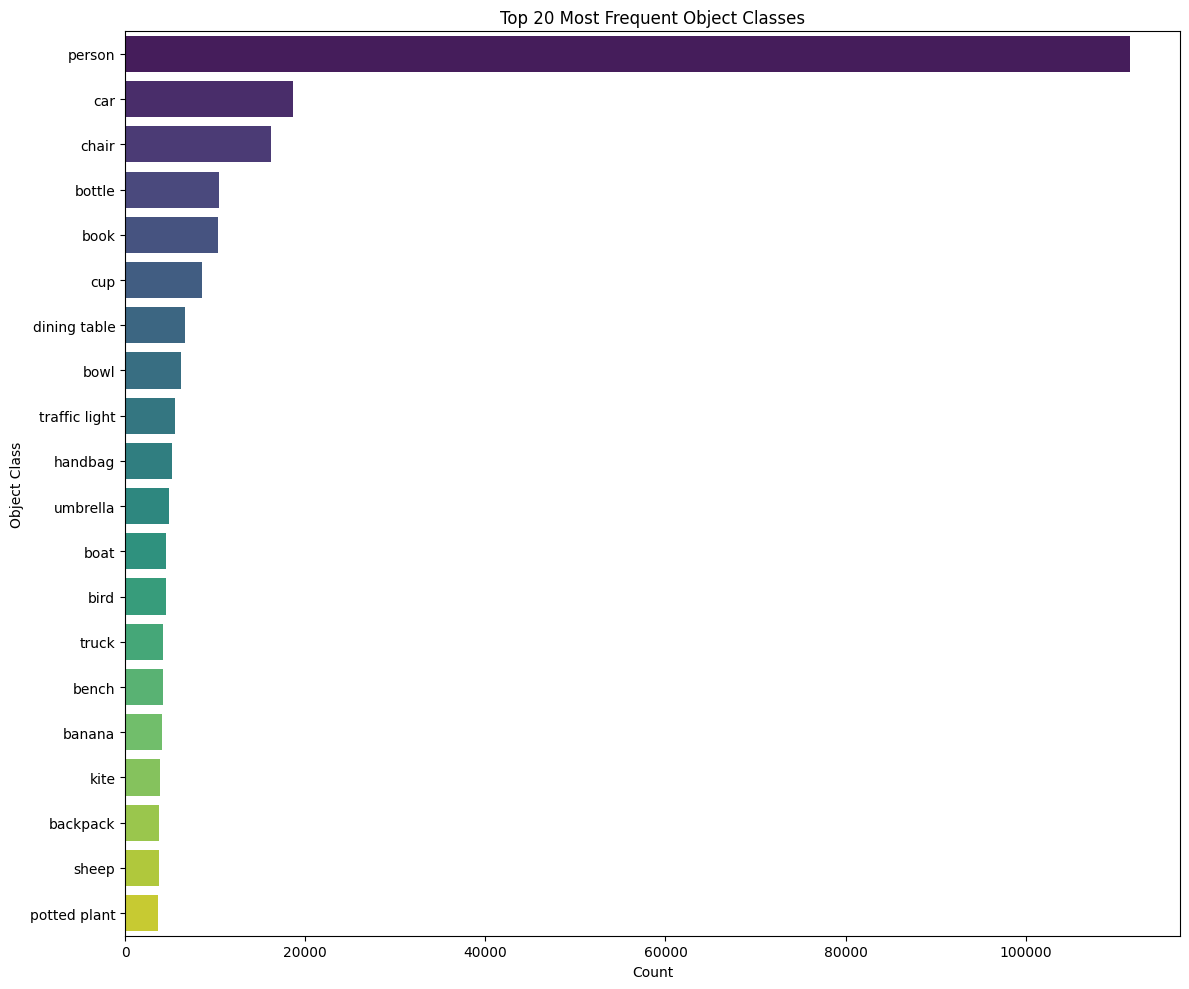

In [ ]:
# Object Class Distribution
category_counts = Counter(all_categories)
df_categories = pd.DataFrame(category_counts.items(), columns=['category_id', 'count'])
df_categories['class_name'] = df_categories['category_id'].apply(lambda x: class_names[x])
df_categories = df_categories.sort_values('count', ascending=False)

plt.figure(figsize=(12, 10))
sns.barplot(x='count', y='class_name', data=df_categories.head(20), palette='viridis')
plt.title('Top 20 Most Frequent Object Classes')
plt.xlabel('Count')
plt.ylabel('Object Class')
plt.tight_layout()
plt.savefig("eda_plots/class_distribution.png")
print("Saved class_distribution.png")

### Insight: Significant Class Imbalance

The COCO dataset exhibits a strong class imbalance, with the person class being overwhelmingly dominant. This means the model will be very good at detecting people, but potentially less reliable for rarer, yet critical, navigation objects like 'traffic light' or 'bench'. To address this, we are supplementing the training data with frames from YouTube POV walkthrough videos. This custom dataset will naturally include more examples of vital navigation objects like benches, stairs, and signs from the first-person perspective, helping to create a more balanced and effective model for our specific use case.

Saved objects_per_image.png


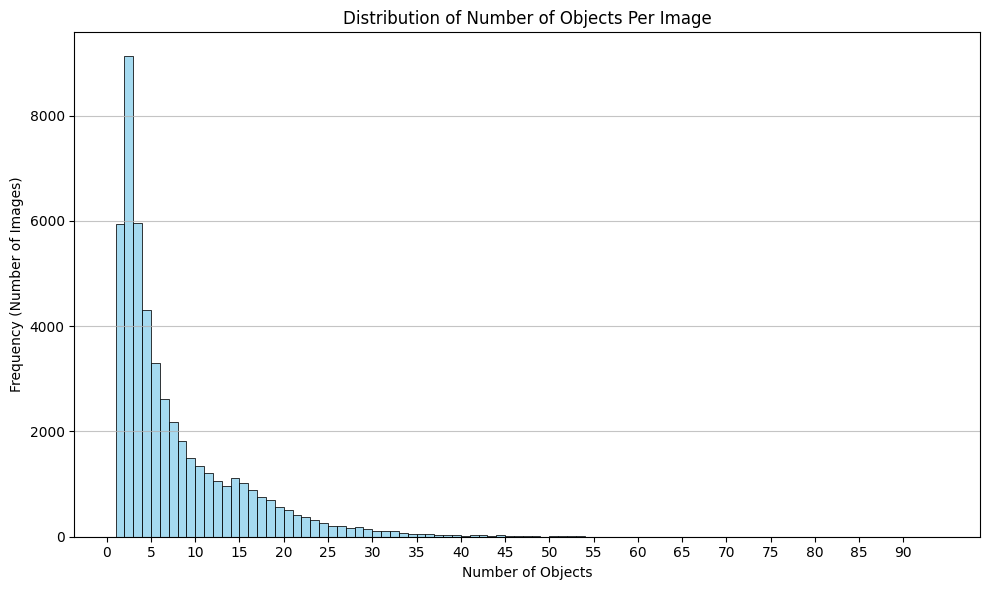

In [ ]:
# Number of Objects Per Image
plt.figure(figsize=(10, 6))
sns.histplot(num_objects_per_image, bins=range(1, max(num_objects_per_image) + 2), kde=False, color='skyblue')
plt.title('Distribution of Number of Objects Per Image')
plt.xlabel('Number of Objects')
plt.ylabel('Frequency (Number of Images)')
plt.xticks(range(0, max(num_objects_per_image) + 1, 5))
plt.grid(axis='y', alpha=0.75)
plt.tight_layout()
plt.savefig("eda_plots/objects_per_image.png")
print("Saved objects_per_image.png")

### Insight: Varied Scene Complexity
The dataset contains a healthy mix of simple and complex scenes. While most images have **fewer than 10 objects**, the long tail of the distribution shows a significant number of crowded images with up to 90 objects. This is beneficial as it will train the model to perform reliably in both sparse environments (like an empty corridor) and busy ones (like a crowded street), reflecting real-world navigational challenges.

Saved aspect_ratios.png


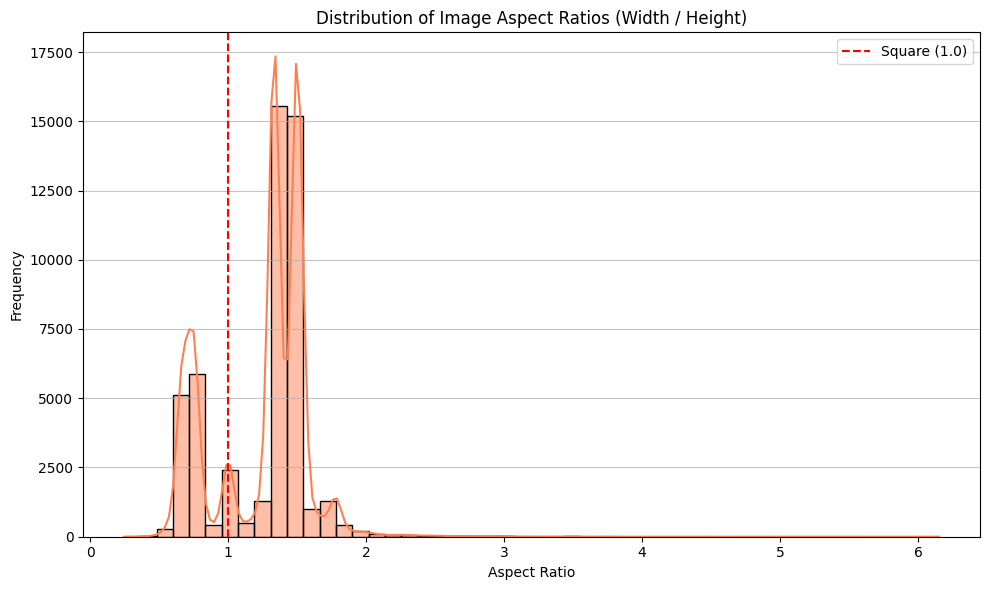

In [ ]:
# Image Aspect Ratios
plt.figure(figsize=(10, 6))
sns.histplot(image_aspect_ratios, bins=50, kde=True, color='coral')
plt.axvline(1.0, color='r', linestyle='--', label='Square (1.0)')
plt.title('Distribution of Image Aspect Ratios (Width / Height)')
plt.xlabel('Aspect Ratio')
plt.ylabel('Frequency')
plt.legend()
plt.grid(axis='y', alpha=0.75)
plt.tight_layout()
plt.savefig("eda_plots/aspect_ratios.png")
print("Saved aspect_ratios.png")

### Insight: Landscape Orientation Dominance
The images are heavily biased towards a **landscape aspect ratio** (wider than they are tall), with peaks around 1.33 and 1.5. This presents a potential challenge, as the primary use case for our Vision Assist application will be on a smartphone held in a **portrait orientation**. To mitigate this, our custom dataset of YouTube frames must include a substantial amount of vertically-oriented video to ensure the model generalizes well to the target deployment device.

Saved bbox_areas.png


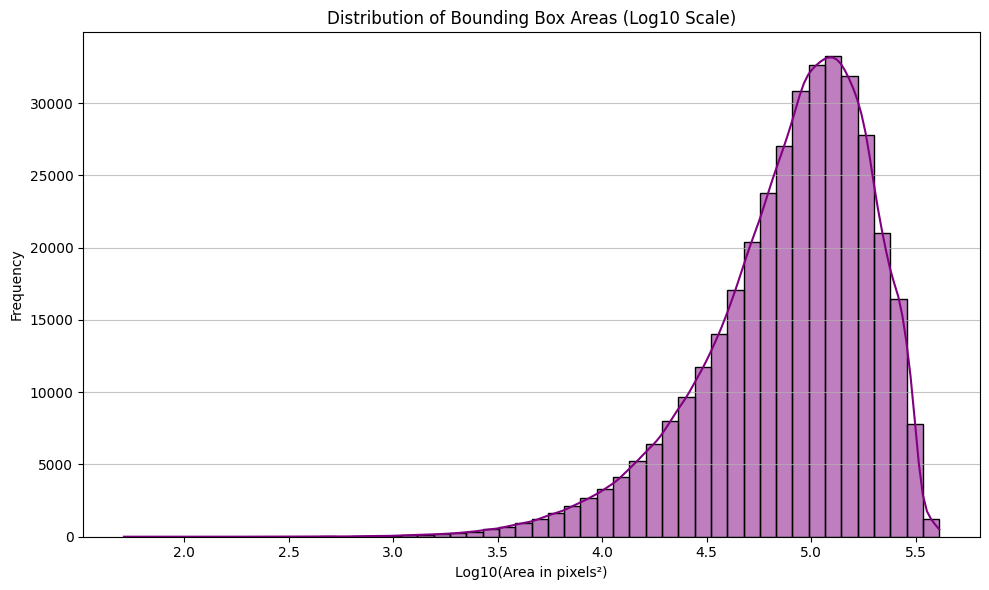

In [ ]:
# Bounding Box Areas (Log Scale)
plt.figure(figsize=(10, 6))
# Use log of areas for better visualization, adding 1 to avoid log(0)
log_areas = np.log10([area + 1 for area in bbox_areas])
sns.histplot(log_areas, bins=50, kde=True, color='purple')
plt.title('Distribution of Bounding Box Areas (Log10 Scale)')
plt.xlabel('Log10(Area in pixels²)')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.tight_layout()
plt.savefig("eda_plots/bbox_areas.png")
print("Saved bbox_areas.png")


### Insight: Good Distribution of Object Sizes
The bounding box areas, when viewed on a log scale, show a balanced, bell-shaped distribution. This indicates the model will be trained on a good variety of **small, medium, and large objects**. For a navigation aid, detecting small objects is crucial as they often represent distant hazards. While the distribution is good, we must carefully evaluate the model's performance on smaller-scale objects to ensure it can provide timely warnings to the user.


Saved object_locations_heatmap.png


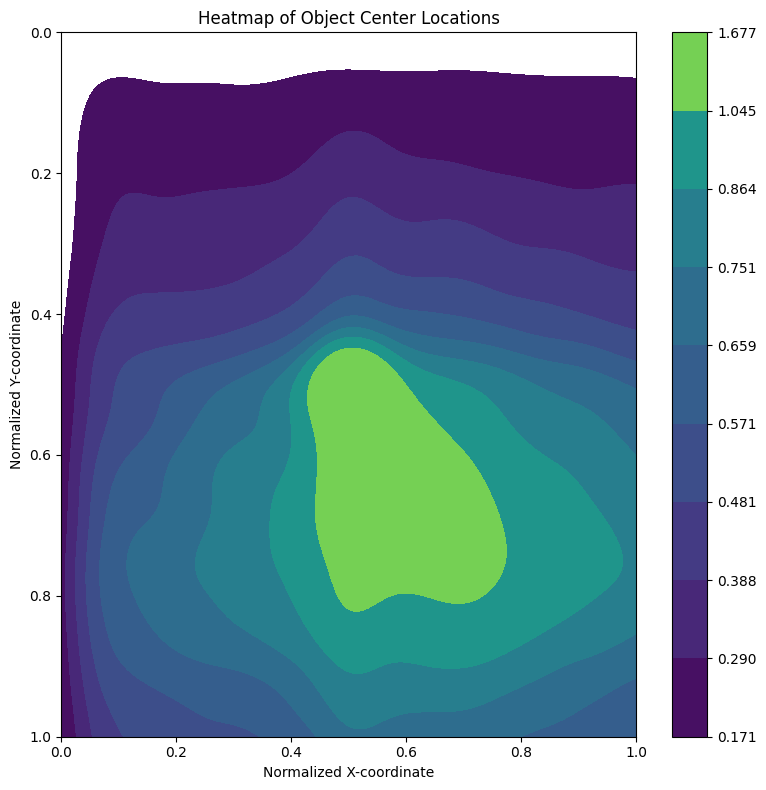

In [ ]:
# Heatmap of Object Locations
df_centers = pd.DataFrame(bbox_centers, columns=['x_center', 'y_center'])

plt.figure(figsize=(8, 8))
sns.kdeplot(data=df_centers, x='x_center', y='y_center', fill=True, cmap='viridis', cbar=True)
plt.title('Heatmap of Object Center Locations')
plt.xlabel('Normalized X-coordinate')
plt.ylabel('Normalized Y-coordinate')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.gca().invert_yaxis() # Invert y-axis to match image coordinates (0,0 at top-left)
plt.tight_layout()
plt.savefig("eda_plots/object_locations_heatmap.png")
print("Saved object_locations_heatmap.png")

### Insight: Central and Lower Bias in Object Locations

The heatmap reveals a significant data bias: objects in the COCO dataset are heavily concentrated in the center and lower half of the image frame. This means the model will be well-trained to detect objects directly ahead but may be unreliable at identifying hazards in the periphery, especially in the upper regions. This is a critical weakness for a navigation aid, as the model could fail to see overhanging obstacles like signs or tree branches. Our custom dataset must therefore include annotated examples of these high-up hazards to ensure user safety.

/tmp/ipython-input-1379276563.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered_ratios['aspect_ratio'] = df_filtered_ratios['aspect_ratio'].clip(0, 5)
/tmp/ipython-input-1379276563.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_filtered_ratios, x='aspect_ratio', y='class_name', palette='Set2')


Saved object_aspect_ratios.png


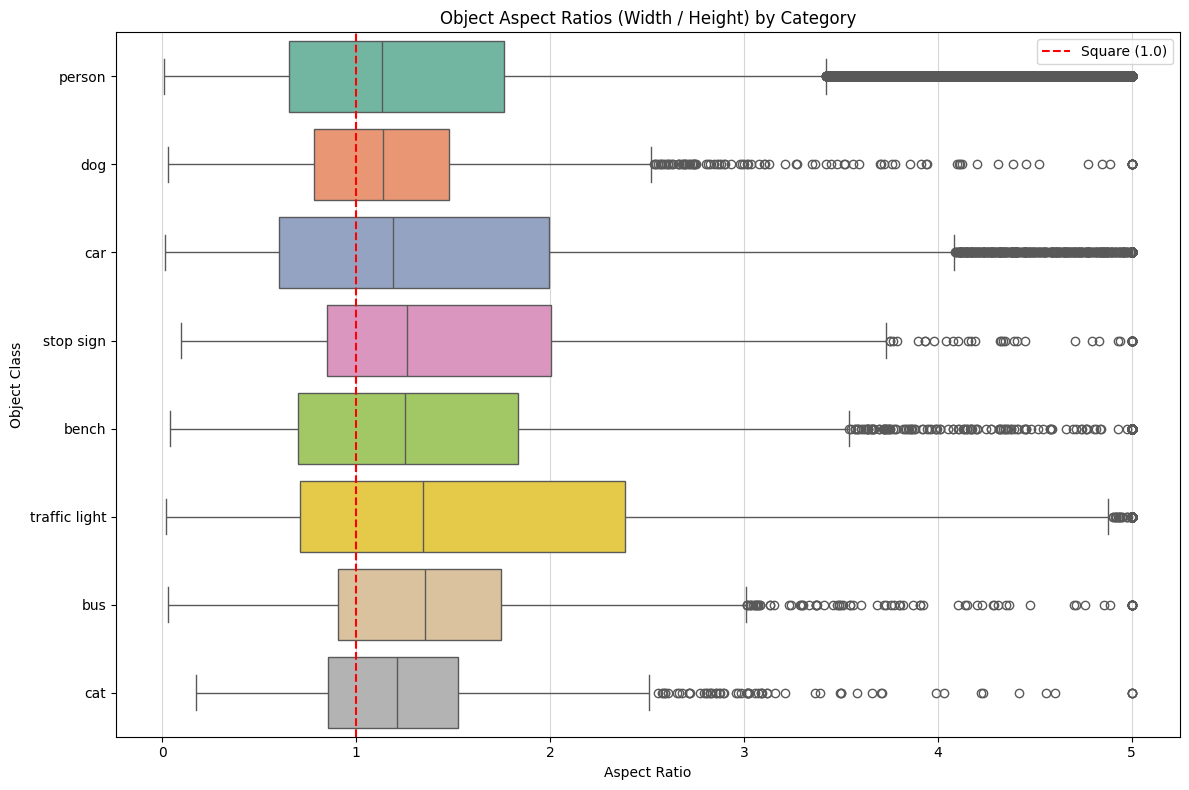

In [ ]:
# Box Plot of Object Aspect Ratios by Category
df_bbox_ratios = pd.DataFrame(bbox_aspect_ratios_by_cat)
df_bbox_ratios['class_name'] = df_bbox_ratios['category_id'].apply(lambda x: class_names[x])

# Select a few interesting classes for clarity
selected_classes = ['person', 'car', 'traffic light', 'bench', 'bus', 'stop sign', 'cat', 'dog']
df_filtered_ratios = df_bbox_ratios[df_bbox_ratios['class_name'].isin(selected_classes)]

# Clip extreme outliers for better visualization
df_filtered_ratios['aspect_ratio'] = df_filtered_ratios['aspect_ratio'].clip(0, 5)


plt.figure(figsize=(12, 8))
sns.boxplot(data=df_filtered_ratios, x='aspect_ratio', y='class_name', palette='Set2')
plt.axvline(1.0, color='r', linestyle='--', label='Square (1.0)')
plt.title('Object Aspect Ratios (Width / Height) by Category')
plt.xlabel('Aspect Ratio')
plt.ylabel('Object Class')
plt.legend()
plt.grid(axis='x', alpha=0.5)
plt.tight_layout()
plt.savefig("eda_plots/object_aspect_ratios.png")
print("Saved object_aspect_ratios.png")

### Insight: Distinct Object Shapes by Category

This plot reveals the distinct shapes of different objects by visualizing their aspect ratios. It confirms that objects like person and traffic light are typically taller than they are wide (aspect ratio < 1), while car and bus are wider than they are tall (aspect ratio > 1). This is valuable for diagnosing model errors; for example, a failure to detect a person lying down could be explained by the model being primarily trained on standing (tall) examples. This highlights the need to include varied object poses in our custom dataset to build a more robust model.
